Beer3 POSmode manuscript
============

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
from IPython.display import display
from lda_for_fragments import Ms2Lda

<h2>1. Feature Extraction</h2>

There are two ways to generate the input matrices, described below in option (a) and (b).

<h3>a. Loading Existing Input Matrices</h3>

You can run the R feature extraction pipeline separately to produce the necessary input matrices for MS2LDA. All the R scripts necessary to perform feature extraction can be found in the "R" folder (one level above from the current "notebooks" folder you're in now). 

The entry point to the pipeline is **R/MS1MS2_MatrixGeneration.R**, so load that file in your favourite R development environment (e.g. RStudio), set the working directory to the "R" folder. Next, you'd need to configure all the parameters of the pipeline. This can be found in **config.yml** file. The default parameters provided there were were for our data generated on pHILIC-MS and HILIC-MS runs in positive ionisation mode. You can try with these values first and modify them as necessary if you aren't getting sensible results in the count matrices that can be used by LDA.

Note: RMassBank is one of the dependencies of the pipeline. RMassBank relies on rJava. The following is a common problem that you might encounter when configuring rJava : http://stackoverflow.com/questions/12872699/error-unable-to-load-installed-packages-just-now. 

In the cell below, we load some CSV files produced after running the feature extraction pipeline in R.

In [ ]:
fragment_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_fragments.csv'
neutral_loss_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_losses.csv'
mzdiff_filename = None
ms1_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_ms1.csv'
ms2_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_ms2.csv'
ms2lda = Ms2Lda.lcms_data_from_R(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                             ms1_filename, ms2_filename)

<h3>b. Running the Feature Extraction Pipeline</h3>

For convenience, we've also provided a wrapper method (shown below) in MS2-LDA to call the the feature extraction pipeline. This takes as input the full scan and fragmentation files (defined in config_filename) and produces the various count matrices used as input to LDA.

Note: Since we're calling R codes from Python, this depends on http://rpy.sourceforge.net/, which doesn't seem to be well-supported in Windows.

In [ ]:
# path to the folder containing the R scripts used for feature extraction 
script_folder = '/home/joewandy/git/metabolomics_tools/justin/R'

# path to the configuration file for feature extraction
config_filename = os.path.join(script_folder, 'config.yml')

# too many warning messages printed from R
import warnings
warnings.filterwarnings("ignore")

# run the feature extraction pipeline, this will run for a long time!!
ms2lda = Ms2Lda.run_feature_extraction(script_folder, config_filename)

<hr/>

<h2>2. Analysis</h2>

<h3>a. Run LDA</h3>

Once the data has been loaded by performing either step 1(a) or 1(b), we're now ready to run LDA analysis.

In [ ]:
### all the parameters you need to specify to run LDA ###

n_topics = 300 # 300 - 400 topics from cross-validation
n_samples = 1000 # 100 is probably okay for testing. For manuscript, use > 500-1000.
n_burn = 0 # if 0 then we only use the last sample
n_thin = 1 # every n-th sample to use for averaging after burn-in. Ignored if n_burn = 0
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

ms2lda.run_lda(n_topics, n_samples, n_burn, n_thin, alpha, beta)

<h3>b. (Optional) In-silico Annotation using SIRIUS</h3>

For the purpose of visualisation in step 3(c), we can annotate the MS1 and MS2 peaks using [SIRIUS](http://bio.informatik.uni-jena.de/software/sirius/), an in-silico fragmentation tool written in Java. At the moment, each parent MS1 peak and its associated MS2 spectra are run through SIRIUS separately. Isotopic information, which can be used to improve annotation, is not used yet.

If you run this annotation step before saving the project in step (c) below, the annotation information will be saved into the ms1 and ms2 peak info too.

In [ ]:
# sirius_platform specifies the profile used by SIRIUS
# ppm_max is the mass tolerance used by SIRIUS when assigning elemental formulae
# mode is either 'pos' or 'neg'
# max_ms1 excludes any MS1 with m/z > 400 from annotation since it takes too long to process
ms2lda.annotate_with_sirius(sirius_platform='orbitrap', ppm_max=5, mode='pos', max_ms1=400)

In [ ]:
display(ms2lda.ms1)

In [ ]:
display(ms2lda.ms2)

<h3>c. (Optional) In-silico Annotation using EF Assigner</h3>

If you have not installed SIRIUS, we have also provided a simple in-silico annotation method (EF Assigner) written completely in Python. The method works by combinatorially enumerating all candidate formulae that can be produced by the precursor mass, applying the 7 golden rules to reduce the candidate set and returning the formula closest in mass to the observed precursor mass as the 'top hit'. This method does not assign formulae to the losses, only the fragments.

Similar to the SIRIUS annotation above, we can call EF Assigner as shown in the cells below. First we clear all existing annotations in the MS1 and MS2 dataframes.

In [3]:
# removes all the previous annotations by deleting the 'annotation' column from the ms1 & ms2 dataframes
ms2lda.remove_all_annotations()

Here we annotate the MS1 peaks, specifying some heuristic rules on the maximum occurrences of the atoms in the elemental formulae.

The set do_rule_8 parameter below adds the following atoms and limit their max no. of occurrences 
(defined in max_occurrences):
- N   max occurrence 1
- C13 max occurrence 1
- F   max occurrence 2
- Cl  max occurrence 2

If you want to restrict sulphur and phosphor atoms too, use this instead and change the numbers

    max_occurrences = {'N':1, 'S': 1, 'P': 1, C13':1, 'F':2, 'Cl':2}
    
*n_stages* defines the number of stages in the annotation. If it's set to 2, then in the first stage, we perform elemental formulae search using the atoms: CHNOPS. After that, in the second stage, any mass in the list with no results will be re-annotated with the addition of C13, F, Cl to the list of atoms to search.

In [4]:
max_occurrences = {'N':6, 'S': 2, 'P': 2, 'C13':1, 'F':0, 'Cl':0}
n_stages = 2
tol = 3

ms2lda.annotate_peaks(mode='pos', target='ms1', ppm=5, max_mass=400, 
                      rule_8_max_occurrences=max_occurrences, n_stages=n_stages)

***********************************
Annotating ms1
***********************************

- mode = pos
- ppm = 5
- scale_factor = 1000
- max_mass = 400

F removed from the list of atoms to search
Cl removed from the list of atoms to search
Atoms being considered = ['H', 'C', 'N', 'O', 'P', 'S']
Searching for neutral mass 69.057889 (1/1422) at tolerance 5 ppm
- found 2 candidate(s), best formula = C4H8N
Searching for neutral mass 71.073523 (2/1422) at tolerance 5 ppm
- found 2 candidate(s), best formula = C4H10N
Searching for neutral mass 71.073542 (3/1422) at tolerance 5 ppm
- found 2 candidate(s), best formula = C4H10N
Searching for neutral mass 72.057512 (4/1422) at tolerance 5 ppm
- found 2 candidate(s), best formula = C4H9O
Searching for neutral mass 75.032040 (5/1422) at tolerance 5 ppm
- found 1 candidate(s), best formula = C2H6O2N
Searching for neutral mass 75.068422 (6/1422) at tolerance 5 ppm
- found 1 candidate(s), best formula = C3H10ON
Searching for neutral mass 80.026238 (7/

In [ ]:
display(ms2lda.ms1)

We can also annotate the MS2 fragments/losses by specifying different *target* parameter. In the example below, we annotate the MS2 fragment while specifying a conditional mass tolerance to be used in the search. 

We allow the *ppm* parameter to be specified as either fixed tolerance, e.g. in this form:

    tol = 5

or as conditional tolerances as shown in the example below, which for mass <= 80, we use a tolerance of 5 ppm while for mass > 80 and <= 400, we use a tolerance of 10 ppm.

    tol = [(80, 5), (400, 10)]

In [5]:
max_occurrences = {'N':6, 'S': 2, 'P': 2, 'C13':1, 'F':0, 'Cl':0}
n_stages = 1
tol = [(70, 10), (200, 5)]

# annotate the elemental formulae of MS2 fragments
ms2lda.annotate_peaks(mode='pos', target='ms2_fragment', ppm=tol, max_mass=200, 
                      rule_8_max_occurrences=max_occurrences, n_stages=n_stages)

***********************************
Annotating ms2_fragment
***********************************

- mode = pos
- ppm = [(70, 10), (200, 5)]
- scale_factor = 1000
- max_mass = 200

F removed from the list of atoms to search
Cl removed from the list of atoms to search
Atoms being considered = ['H', 'C', 'N', 'O', 'P', 'S']
Searching for neutral mass 49.008374 (1/3752) at tolerance 10 ppm
- found 1 candidate(s), best formula = H5NP
Searching for neutral mass 49.992244 (8/3752) at tolerance 10 ppm
- found 1 candidate(s), best formula = H4OP
Searching for neutral mass 50.016104 (9/3752) at tolerance 10 ppm
- found 2 candidate(s), best formula = C4H3
Searching for neutral mass 51.011174 (27/3752) at tolerance 10 ppm
- found 1 candidate(s), best formula = C3H2N
Searching for neutral mass 51.994914 (33/3752) at tolerance 10 ppm
- found 1 candidate(s), best formula = C3HO
Searching for neutral mass 51.995314 (34/3752) at tolerance 10 ppm
- found 1 candidate(s), best formula = C3HO
Searching for 

In [ ]:
display(ms2lda.ms2)

We can also annotate the neutral losses. Set the *target* parameter to 'ms2_loss' and *mode* to 'none'

In [6]:
# we can also annotate the neutral losses
max_occurrences = {'N':6, 'S': 2, 'P': 2, 'C13':1, 'F':0, 'Cl':0}
n_stages = 1
tol = [(40, 20), (200, 10)]
ms2lda.annotate_peaks(mode='none', target='ms2_loss', ppm=tol, max_mass=200, n_stages=n_stages, rule_8_max_occurrences=max_occurrences)

***********************************
Annotating ms2_loss
***********************************

- mode = none
- ppm = [(40, 20), (200, 10)]
- scale_factor = 1000
- max_mass = 200

F removed from the list of atoms to search
Cl removed from the list of atoms to search
Atoms being considered = ['H', 'C', 'N', 'O', 'P', 'S']
Searching for neutral mass 26.015430 (11/744) at tolerance 20 ppm
- found 1 candidate(s), best formula = C2H2
Searching for neutral mass 27.011010 (12/744) at tolerance 20 ppm
- found 1 candidate(s), best formula = CHN
Searching for neutral mass 28.030750 (15/744) at tolerance 20 ppm
- found 1 candidate(s), best formula = C2H4
Searching for neutral mass 29.026130 (17/744) at tolerance 20 ppm
- found 1 candidate(s), best formula = CH3N
Searching for neutral mass 30.010490 (18/744) at tolerance 20 ppm
- found 1 candidate(s), best formula = CH2O
Searching for neutral mass 31.042040 (19/744) at tolerance 20 ppm
- found 1 candidate(s), best formula = CH5N
Searching for neutral

In [ ]:
display(ms2lda.ms2)

<h3>d. (Optional) Saving Project</h3>

Save the whole project so we don't have to re-run everything the next time ..

In [7]:
# leave the message parameter out if nothing to say
ms2lda.save_project('results/Manuscript_Beer3POSmode_EFassignerALL.project', message="Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses")

Project saved to results/Manuscript_Beer3POSmode_EFassignerALL.project time taken = 13.2426261309


<hr/>

<h2>3. Results</h2>

<h3>a. Resuming Project (Optional)</h3>

If you saved the project in step (2c), you can resume from here the next time you load this notebook ..

In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import pylab as plt
from IPython.display import display
from lda_for_fragments import Ms2Lda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassignerALL.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassignerALL.project time taken = 16.1587912522
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/10/15 14:28:46
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [ ]:
display(ms2lda.ms1)

In [ ]:
display(ms2lda.ms2)

<h3>b. Thresholding</h3>

For the purpose of visualisation only, we threshold the document-topic and topic-word distributions produced by LDA, so we can say which topics are used in which documents, and which words 'belongs' to a topic. This needs to be done before step (b) and (c) below.

In [28]:
# Thresholding the doc_topic and topic_word matrices
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

From this point onwards, we will refer to an LDA topic as **Mass2Motif** when interpreting the results.

<h3>c. Print Results</h3>

Print which fragment/loss features occur with probability above the thresholds defined above in each Mass2Motif.

In [ ]:
ms2lda.print_motif_features()

We can also save the output to CSV files

In [9]:
ms2lda.write_results('beer3pos_EFassigner_csv_out')

Writing Mass2Motif features to results/beer3pos_EFassigner_csv_out/beer3pos_EFassigner_csv_out_motifs.csv
Writing features X motifs to results/beer3pos_EFassigner_csv_out/beer3pos_EFassigner_csv_out_features.csv
Writing docs X motifs to results/beer3pos_EFassigner_csv_out/beer3pos_EFassigner_csv_out_docs.csv


<h3>d. Cosine Clustering (optional)</h3>

We plot the cosine clustering of the parent ions to investigate the agreement/difference between peaks that have been clustered by cosine clustering vs motifs from LDA. First we need to construct the clustering. To do this, we can use either the hierarchical clustering with Euclidean distance from scipy or an alternative greedy clustering method we devise, which works as follows: **(1)** find the next unprocessed parent ion having max intensity, **(2)** group this to other parents with cosine similarity over the threshold (0.55), **(3)** repeat until all parents have been processed.


In [7]:
# method is either 'hierarchical' or 'greedy'
# peak_names, clustering = ms2lda.run_cosine_clustering(method='hierarchical', th_clustering=0.80)
peak_names, clustering = ms2lda.run_cosine_clustering(method='greedy', th_clustering=0.55)

In [8]:
print "Found {} clusters".format(np.max(clustering))

Found 309 clusters


Then we pick some Mass2Motifs, e.g. 102 and 220 below, and plot how all the parent ions cluster based on their cosine similarity. The parent ions of interest that have been assigned to the motif (above the threshold) are indicated as red dots in the plot.

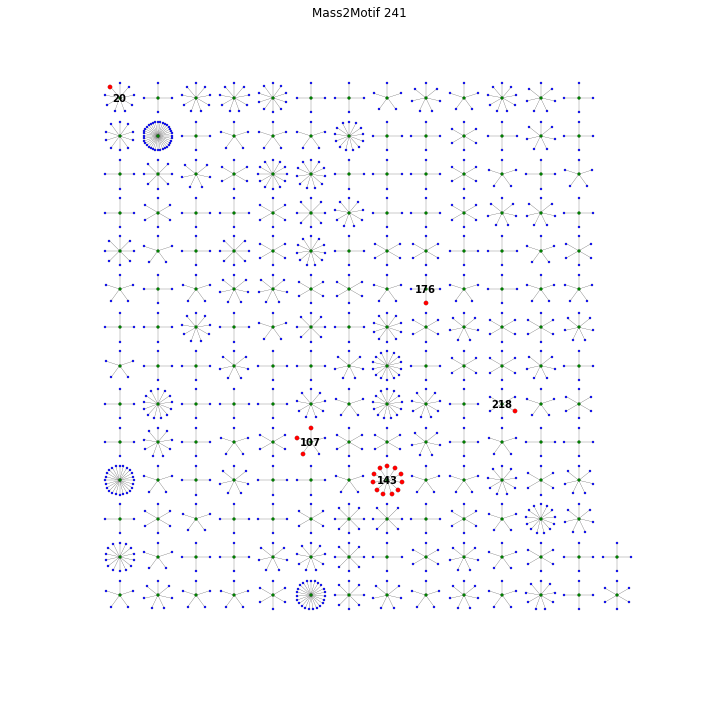

Cluster 20 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16731,16731,0,1,409.09,251.149931,2320696,1,0,0,C11H23O6


Cluster 107 with 3 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
14424,14424,0,1,409.090,235.107715,844300.6875,1,0,0,C6H16O2N6P
14469,14469,0,1,414.273,235.118674,40185984.0000,1,0,0,C10H19O6
14514,14514,0,1,398.577,235.118859,2509060.5000,1,0,0,C11H23OS2


Cluster 143 with 11 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
449,449,0,1,621.074,110.071292,5.439790e+06,1,0,0,C5H8N3
4779,4779,0,1,621.074,156.076767,1.100440e+08,1,0,0,C6H10O2N3
9533,9533,0,1,481.308,198.087292,1.177985e+06,1,0,0,C8H12O3N3
20222,20222,0,1,435.830,277.147397,5.202552e+05,1,0,0,C15H22ON2P
20242,20242,0,1,304.981,277.158207,1.053594e+06,1,0,0,C14H22N4P
20259,20259,0,1,427.098,277.158525,1.081880e+06,1,0,0,C14H22N4P
24713,24713,0,1,240.354,310.212524,1.472855e+06,1,0,0,C16H28O3N3
28706,28706,0,1,503.147,362.216588,6.439100e+05,1,0,0,C21H32O2NS
28718,28718,0,1,903.578,363.175665,8.751166e+05,1,0,0,C27H23O
29110,29110,0,1,465.819,364.161446,1.585506e+06,1,0,0,C15H26O9N


Cluster 176 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9236,9236,0,1,510.903,195.087613,1369505.5,1,0,0,C8H19OS2


Cluster 218 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19224,19224,0,1,592.258,272.087582,916740.3125,1,0,0,C12H19O2NPS


In [9]:
G, cluster_interests = ms2lda.plot_cosine_clustering(241, clustering, peak_names)
for cluster in sorted(cluster_interests):
    interest_members = cluster_interests[cluster]
    print "Cluster %d with %d parent ion(s) of interest:" % (cluster, len(interest_members))
    display(ms2lda.ms1[ms2lda.ms1['peakID'].isin(interest_members)])

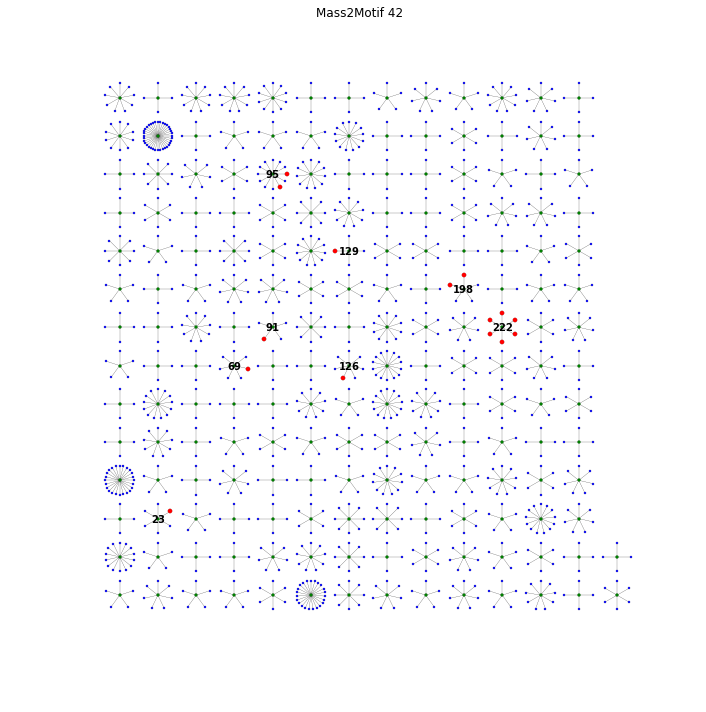

Cluster 23 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9348,9348,0,1,682.745,196.081556,522384.9375,1,0,0,C6H14O6N


Cluster 69 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2572,2572,0,1,636.289,134.064044,991313,1,0,0,C5H12ONS


Cluster 91 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5213,5213,0,1,385.068,161.092055,810818.375,1,0,0,C6H13O3N2


Cluster 95 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
17735,17735,0,1,618.594,260.052756,1120613.875,1,0,0,C9H14O2N3S2
17791,17791,0,1,604.701,260.114076,13904277.000,1,0,0,C11H18O6N


Cluster 126 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
7052,7052,0,1,590.942,176.055358,4329780.5,1,0,0,C6H10O5N


Cluster 129 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
17713,17713,0,1,263.085,259.165081,537934.5,1,0,0,C14H28PS


Cluster 198 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
99,99,0,1,646.272,87.044055,12338473.0,1,0,0,C4H7O2
105,105,0,1,636.289,87.055276,735020.5,1,0,0,C3H7ON2


Cluster 222 with 6 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2511,2511,0,1,636.289,133.060729,25519770.0000,1,0,0,C4H9O3N2
2564,2564,0,1,552.287,134.032492,1079868.1250,1,0,0,H5N6S[C13]
2566,2566,0,1,614.625,134.044727,1106318.8750,1,0,0,C4H8O4N
6924,6924,0,1,512.320,175.001652,971725.9375,1,0,0,C3H4O3N4P
6957,6957,0,1,513.556,175.071339,1157693.2500,1,0,0,C8H16PS
17993,17993,0,1,628.816,262.103306,823124.0625,1,0,0,C11H21O2NPS


In [10]:
G, cluster_interests = ms2lda.plot_cosine_clustering(42, clustering, peak_names)
for cluster in sorted(cluster_interests):
    interest_members = cluster_interests[cluster]
    print "Cluster %d with %d parent ion(s) of interest:" % (cluster, len(interest_members))
    display(ms2lda.ms1[ms2lda.ms1['peakID'].isin(interest_members)])

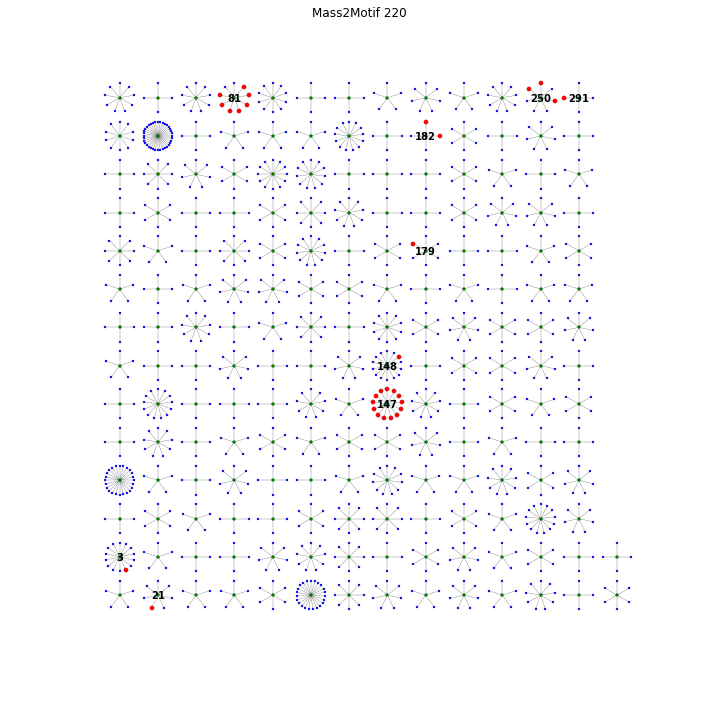

Cluster 3 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33982,33982,0,1,594.743,561.694165,836040,1,0,0,NaN


Cluster 21 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31697,31697,0,1,659.996,399.144265,3810192.5,1,0,0,C16H32O5PS2


Cluster 81 with 7 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
29287,29287,0,1,635.046,364.794770,6907533.000,1,0,0,NaN
29387,29387,0,1,640.068,365.105354,8324832.000,1,0,0,C9H21O13N2
29487,29487,0,1,651.276,365.105484,3250183.750,1,0,0,C9H21O13N2
29587,29587,0,1,635.046,365.129089,3537895.500,1,0,0,C18H18ON6P
29774,29774,0,1,630.064,365.203025,1058804.375,1,0,0,C26H25N2
29911,29911,0,1,636.289,365.463382,1274517.750,1,0,0,NaN
33896,33896,0,1,635.046,546.688859,1340515.375,1,0,0,NaN


Cluster 147 with 13 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2632,2632,0,1,495.514,136.061801,5.998152e+08,1,0,0,C5H6N5
16867,16867,0,1,439.647,252.108914,2.963589e+07,1,0,0,C9H18O7N
18872,18872,0,1,469.707,268.103893,8.295168e+06,1,0,0,C9H18O8N
23378,23378,0,1,398.577,298.096813,3.102808e+06,1,0,0,C10H20O7NS
23395,23395,0,1,386.308,298.096820,2.876562e+06,1,0,0,C10H20O7NS
23497,23497,0,1,370.655,300.084392,1.123364e+06,1,0,0,C12H18O2N3S2
23504,23504,0,1,381.023,300.084407,1.712000e+06,1,0,0,C12H18O2N3S2
23511,23511,0,1,387.897,300.084487,2.229831e+06,1,0,0,C12H18O2N3S2
25030,25030,0,1,474.881,314.092108,5.692797e+05,1,0,0,C13H21N3PS2
25197,25197,0,1,500.483,318.095074,7.648418e+05,1,0,0,C14H17N5PS


Cluster 148 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19012,19012,0,1,469.707,269.107194,844952.8125,1,0,0,C10H23O4P2


Cluster 179 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16422,16422,0,1,494.275,249.120632,698935,1,0,0,C9H21N4S2


Cluster 182 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
26178,26178,0,1,462.109,332.110599,1729951.0,1,0,0,C15H19N5PS
26183,26183,0,1,448.381,332.110602,1373344.5,1,0,0,C15H19N5PS


Cluster 250 with 3 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
21436,21436,0,1,398.577,282.119498,4937815.500,1,0,0,C10H20O8N
21466,21466,0,1,387.897,282.119535,4595782.000,1,0,0,C10H20O8N
31388,31388,0,1,489.128,388.147588,773630.375,1,0,0,C14H30O7NS2


Cluster 291 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
10254,10254,0,1,361.963,204.1232,530557.625,1,0,0,C9H18O4N


In [11]:
G, cluster_interests = ms2lda.plot_cosine_clustering(220, clustering, peak_names)
for cluster in sorted(cluster_interests):
    interest_members = cluster_interests[cluster]
    print "Cluster %d with %d parent ion(s) of interest:" % (cluster, len(interest_members))
    display(ms2lda.ms1[ms2lda.ms1['peakID'].isin(interest_members)])

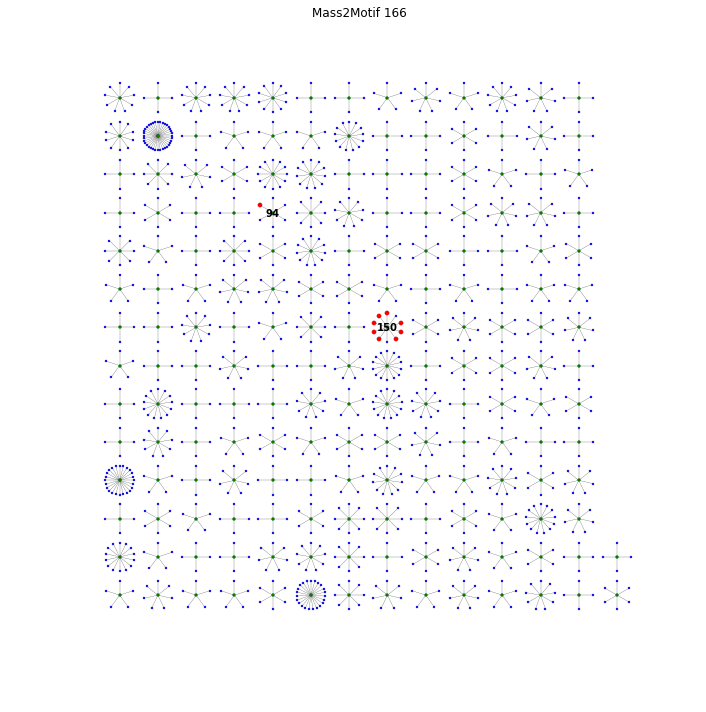

Cluster 94 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9702,9702,0,1,554.77,198.123694,1850198.125,1,0,0,C9H16O2N3


Cluster 150 with 8 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1323,1323,0,1,478.834,126.066215,24917608.0000,1,0,0,C5H8ON3
4639,4639,0,1,490.365,155.045015,571738.6875,1,0,0,C6H7O3N2
4646,4646,0,1,501.725,155.045062,851736.0000,1,0,0,C6H7O3N2
13752,13752,0,1,640.068,230.095734,1287737.8750,1,0,0,C9H16O2N3S
15475,15475,0,1,477.597,242.102556,545534.4375,1,0,0,C11H16O5N
15572,15572,0,1,487.891,242.157790,960250.0625,1,0,0,C13H24ONS
17544,17544,0,1,526.108,258.150560,1603002.0000,1,0,0,NaN
33202,33202,0,1,478.834,483.219946,1152641.7500,1,0,0,NaN


In [12]:
G, cluster_interests = ms2lda.plot_cosine_clustering(166, clustering, peak_names)
for cluster in sorted(cluster_interests):
    interest_members = cluster_interests[cluster]
    print "Cluster %d with %d parent ion(s) of interest:" % (cluster, len(interest_members))
    display(ms2lda.ms1[ms2lda.ms1['peakID'].isin(interest_members)])

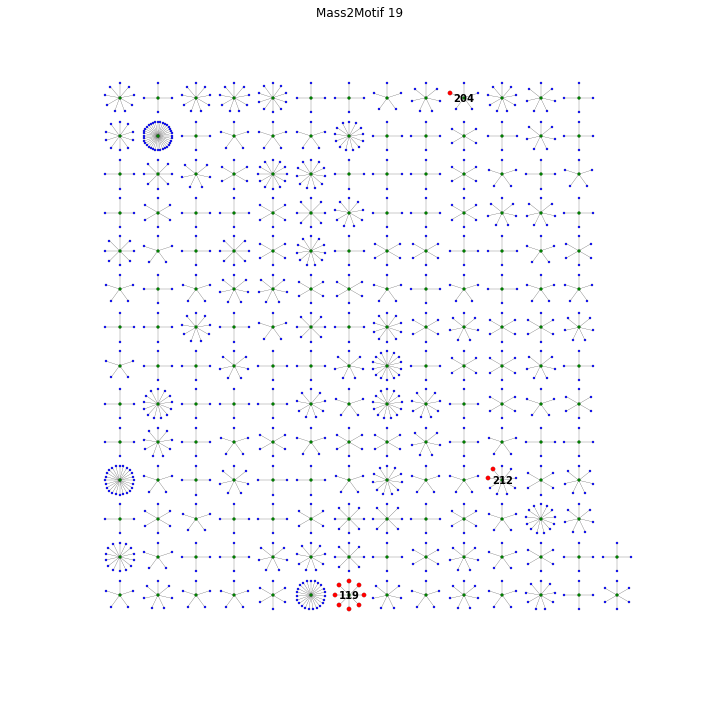

Cluster 119 with 8 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18337,18337,0,1,1100.580,265.154506,641240.3750,1,0,0,C8H22O2N6P
23984,23984,0,1,613.388,307.099839,1956959.8750,1,0,0,C7H19O11N2
24157,24157,0,1,547.239,307.176740,1265813.8750,1,0,0,C15H31O2S2
25054,25054,0,1,269.685,314.138614,880273.1250,1,0,0,C12H29O2NPS2
30232,30232,0,1,295.711,369.118176,577575.9375,1,0,0,C21H23O2P2
33376,33376,0,1,615.862,498.259936,2480739.0000,1,0,0,NaN
33815,33815,0,1,263.085,540.270748,7450965.5000,1,0,0,NaN
33851,33851,0,1,276.096,540.330637,604547.4375,1,0,0,NaN


Cluster 204 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9259,9259,0,1,378.542,195.113046,612365.625,1,0,0,C10H15O2N2


Cluster 212 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9034,9034,0,1,364.448,194.081159,4002022.25,1,0,0,C10H12O3N
9071,9071,0,1,378.542,194.081202,2941392.25,1,0,0,C10H12O3N


In [13]:
G, cluster_interests = ms2lda.plot_cosine_clustering(19, clustering, peak_names)
for cluster in sorted(cluster_interests):
    interest_members = cluster_interests[cluster]
    print "Cluster %d with %d parent ion(s) of interest:" % (cluster, len(interest_members))
    display(ms2lda.ms1[ms2lda.ms1['peakID'].isin(interest_members)])

<h3>e. Visualisation</h3>

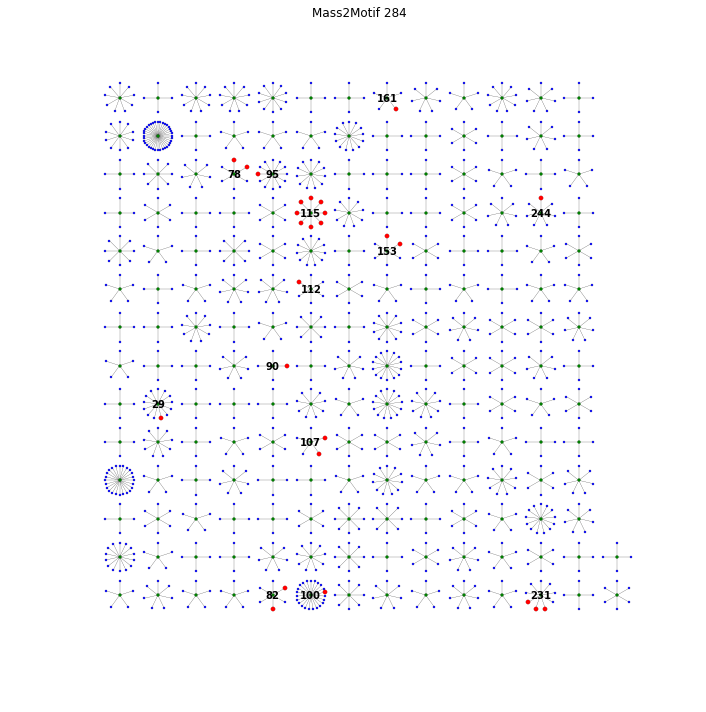

Cluster 29 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4427,4427,0,1,395.725,152.128128,625827.0625,1,0,0,NaN


Cluster 78 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1385,1385,0,1,667.614,127.038947,5368997.00,1,0,0,C6H7O3
1398,1398,0,1,467.234,127.038997,2580205.25,1,0,0,C6H7O3


Cluster 82 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
17855,17855,0,1,652.517,261.036946,4255294.0,1,0,0,C11H10N4PS
20322,20322,0,1,652.517,278.063463,1722221.5,1,0,0,C11H13N5PS


Cluster 90 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32048,32048,0,1,210.784,417.167449,1963761.625,1,0,0,NaN


Cluster 95 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
26285,26285,0,1,640.068,335.07364,1912592.75,1,0,0,C11H15O10N2


Cluster 100 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4276,4276,0,1,389.139,152.037601,799698.625,1,0,0,C6H7N3P


Cluster 107 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32075,32075,0,1,203.264,417.263413,2814379.750,1,0,0,NaN
32301,32301,0,1,202.025,431.279226,1073411.125,1,0,0,NaN


Cluster 112 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
24268,24268,0,1,661.235,308.133847,669146.25,1,0,0,C16H24ONP2


Cluster 115 with 8 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33,33,0,1,562.308,81.033514,766053.0000,1,0,0,C5H5O
424,424,0,1,667.614,109.028429,1310000.2500,1,0,0,C6H5O2
430,430,0,1,460.835,109.028442,1104494.3750,1,0,0,C6H5O2
3087,3087,0,1,460.835,141.054613,3393543.5000,1,0,0,C7H9O3
9228,9228,0,1,618.594,195.086253,666660.5625,1,0,0,C7H15O6
15218,15218,0,1,257.728,240.122937,598797.8750,1,0,0,C6H19O3N5P
17779,17779,0,1,420.520,260.112596,2118296.2500,1,0,0,C5H19O5N5P
17814,17814,0,1,410.326,260.127845,1268232.7500,1,0,0,C9H19O2N5P


Cluster 153 with 2 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33051,33051,0,1,712.999,471.218580,1796000.375,1,0,0,NaN
34263,34263,0,1,690.253,633.271325,587176.000,1,0,0,NaN


Cluster 161 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
11454,11454,0,1,597.228,212.112713,3364737.25,1,0,0,C7H18O6N


Cluster 231 with 3 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3363,3363,0,1,667.614,145.049507,6715682.0,1,0,0,C6H9O4
3385,3385,0,1,478.834,145.049556,2939408.0,1,0,0,C6H9O4
3404,3404,0,1,467.234,145.049561,7991423.5,1,0,0,C6H9O4


Cluster 244 with 1 parent ion(s) of interest:


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25738,25738,0,1,593.501,326.144565,2051125.75,1,0,0,C16H26O2NP2


In [14]:
G, cluster_interests = ms2lda.plot_cosine_clustering(284, clustering, peak_names)
for cluster in sorted(cluster_interests):
    interest_members = cluster_interests[cluster]
    print "Cluster %d with %d parent ion(s) of interest:" % (cluster, len(interest_members))
    display(ms2lda.ms1[ms2lda.ms1['peakID'].isin(interest_members)])

A visualisation module is provided to explore the results. This can be run in either interactively in the browser or non-interactively by plotting all results in this notebook (which can be a lot of plots!)

<h4>Set Visualisation Parameters</h4>

In [29]:
# If True, an interactive visualisation is shown in a separate tab. 
# You need to interrupt the kernel to stop it once you're done with it (from the menu above, Kernel > Interrupt).
interactive=True

In [30]:
# Used for graph visualisation in the interactive mode only. 
# Specifies the 'special' nodes to be coloured differently.
special_nodes = [
    # you can colour the MS1 peak in the graph
    # 'doc_peakid', where peakid is the peak ID of the MS1 peak    
    # ('doc_21758', 'gold'),
    # Mass2Motif 241
    ('doc_449', '#00BE00'),
    ('doc_33939', '#00BE00'),
    ('doc_20242', '#00BE00'),
    ('doc_20259', '#00BE00'),
    ('doc_24713', '#00BE00'),
    ('doc_28718', '#00BE00'),
    ('doc_28706', '#00BE00'),
    ('doc_20222', '#00BE00'),
    ('doc_4779', '#00BE00'),
    ('doc_29110', '#00BE00'),
    ('doc_9533', '#00BE00'),
    ('doc_14424', '#00BE00'),
    ('doc_16731', '#00BE00'),
    ('doc_14469', '#00BE00'),
    ('doc_14514', '#00BE00'),
    ('doc_9236', '#00BE00'),
    ('doc_33172', '#00BE00'),
    ('doc_25207', '#00BE00'),
    ('doc_4839', '#00BE00'),
    ('doc_4864', '#00BE00'),
    ('doc_19224', '#00BE00'),
    # Mass2Motif 42
    ('doc_6924', '#FF74A2'),
    ('doc_2564', '#FF74A2'),
    ('doc_6957', '#FF74A2'),
    ('doc_2511', '#FF74A2'),
    ('doc_17993', '#FF74A2'),
    ('doc_2566', '#FF74A2'),
    ('doc_2572', '#FF74A2'),
    ('doc_17791', '#FF74A2'),
    ('doc_5213', '#FF74A2'),
    ('doc_17713', '#FF74A2'),
    ('doc_16788', '#FF74A2'),
    ('doc_17735', '#FF74A2'),
    ('doc_16776', '#FF74A2'),
    ('doc_7052', '#FF74A2'),
    ('doc_105', '#FF74A2'),
    ('doc_99', '#FF74A2'),
    ('doc_9348', '#FF74A2'),
    # Mass2Motif 220
    ('doc_23378', '#FF1F1F'),
    ('doc_23395', '#FF1F1F'),
    ('doc_2632', '#FF1F1F'),
    ('doc_31590', '#FF1F1F'),
    ('doc_30514', '#FF1F1F'),
    ('doc_30475', '#FF1F1F'),
    ('doc_16867', '#FF1F1F'),
    ('doc_25197', '#FF1F1F'),
    ('doc_18872', '#FF1F1F'),
    ('doc_33982', '#FF1F1F'),
    ('doc_21436', '#FF1F1F'),
    ('doc_23497', '#FF1F1F'),
    ('doc_23504', '#FF1F1F'),
    ('doc_23511', '#FF1F1F'),
    ('doc_21466', '#FF1F1F'),
    ('doc_31697', '#FF1F1F'),
    ('doc_29774', '#FF1F1F'),
    ('doc_29911', '#FF1F1F'),
    ('doc_19012', '#FF1F1F'),
    ('doc_29287', '#FF1F1F'),
    ('doc_29587', '#FF1F1F'),
    ('doc_29387', '#FF1F1F'),
    ('doc_29487', '#FF1F1F'),
    ('doc_25030', '#FF1F1F'),
    ('doc_33896', '#FF1F1F'),
    ('doc_31388', '#FF1F1F'),
    ('doc_16422', '#FF1F1F'),
    ('doc_26183', '#FF1F1F'),
    ('doc_26178', '#FF1F1F'),
    ('doc_30001', '#FF1F1F'),
    ('doc_10254', '#FF1F1F'),
    ('doc_31141', '#FF1F1F'),
    # Mass2Motif 166
    ('doc_13752', '#d147a3'),
    ('doc_15475', '#d147a3'),
    ('doc_15572', '#d147a3'),
    ('doc_33202', '#d147a3'),
    ('doc_17544', '#d147a3'),
    ('doc_1323', '#d147a3'),
    ('doc_15513', '#d147a3'),
    ('doc_4646', '#d147a3'),
    ('doc_4639', '#d147a3'),
    ('doc_9702', '#d147a3'),
    # Mass2Motif 19
    ('doc_33376', '#00b2b3'),
    ('doc_18337', '#00b2b3'),
    ('doc_33815', '#00b2b3'),
    ('doc_33851', '#00b2b3'),
    ('doc_24157', '#00b2b3'),
    ('doc_25054', '#00b2b3'),
    ('doc_30232', '#00b2b3'),
    ('doc_23984', '#00b2b3'),
    ('doc_9071', '#00b2b3'),
    ('doc_9034', '#00b2b3'),
    ('doc_9259', '#00b2b3'),
    # Mass2Motif 284
    ('doc_17814', '#39ac73'),
    ('doc_33', '#39ac73'),
    ('doc_15218', '#39ac73'),
    ('doc_424', '#39ac73'),
    ('doc_430', '#39ac73'),
    ('doc_9228', '#39ac73'),
    ('doc_17779', '#39ac73'),
    ('doc_3087', '#39ac73'),
    ('doc_26051', '#39ac73'),
    ('doc_32301', '#39ac73'),
    ('doc_1398', '#39ac73'),
    ('doc_34263', '#39ac73'),
    ('doc_32048', '#39ac73'),
    ('doc_25738', '#39ac73'),
    ('doc_32796', '#39ac73'),
    ('doc_17855', '#39ac73'),
    ('doc_4276', '#39ac73'),
    ('doc_32075', '#39ac73'),
    ('doc_26285', '#39ac73'),
    ('doc_33051', '#39ac73'),
    ('doc_1385', '#39ac73'),
    ('doc_20322', '#39ac73'),
    ('doc_3404', '#39ac73'),
    ('doc_4427', '#39ac73'),
    ('doc_33172', '#39ac73'),
    ('doc_11454', '#39ac73'),
    ('doc_3385', '#39ac73'),
    ('doc_24268', '#39ac73'),
    ('doc_3363', '#39ac73'),
    ('doc_17052', '#39ac73'),
    # you can also colour the Mass2Motif in the graph
    ('motif_241', '#009900'),
    ('motif_42', '#FF00FF'),
    ('motif_220', '#FF0606'),
    ('motif_166', '#cc3399'),
    ('motif_19', '#009999'),
    ('motif_284', '#339966')
]

# If nothing ..
# special_nodes = None

In [31]:
# read the annotation assigned to each Mass2Motif from a CSV file
# this could also be stored in e.g. a database
import csv
motif_annotation = {}
for item in csv.reader(open("results/beer3pos_annotation_JJJvdHooft.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    print str(key) + '\t' + val
    motif_annotation[key] = val

# here we set all the motifs having annotations as special nodes too
motif_colour = '#CC0000'
to_add_list = ['motif_' + str(x) for x in motif_annotation.keys()]
for item in to_add_list:
    special_nodes.append((item, motif_colour))

# If nothing ..
# motif_annotation = {} # or just leave the 'additional_info' parameter out when calling plot_lda_fragments below

260	 "Water loss - indicative of a free hydroxyl group"
262	 "Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure"
226	 "Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure"
158	 "Leucine related substructure"
243	 "Conjugation of a phosphate group (H4O4P) substructure"
127	 "Conjugation of a phosphate group (H4O4P) substructure"
174	 "Pyroglutamic acid (pyroglutamate) substructure"
59	 "Pyroglutamic acid (pyroglutamate) substructure"
214	 "Amine loss - suggests free NH2 group in fragmented molecule"
60	 "Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars"
151	 "[proline-H2O] suggests conjugated proline substructure."
40	 "Imidazole group linked to a carboxylgroup through one CH2 group substructure"
284	 "Suggests dihydroxylated benzene ring substructure"
276	 "Alkyl aromatic substructure - suggests aromatic ring with 2-carbon alkyl chain attached"
45	 "Pipecolic

<h4>Run Visualisation</h4>

In [ ]:
ms2lda.plot_lda_fragments(interactive=interactive, to_highlight=special_nodes, additional_info=motif_annotation)

Ranking motifs ...
 - Mass2Motif 0 h-index = 2
 - Mass2Motif 1 h-index = 2
 - Mass2Motif 2 h-index = 1
 - Mass2Motif 3 h-index = 2
 - Mass2Motif 4 h-index = 3
 - Mass2Motif 5 h-index = 5
 - Mass2Motif 6 h-index = 4
 - Mass2Motif 7 h-index = 5
 - Mass2Motif 8 h-index = 3
 - Mass2Motif 9 h-index = 5
 - Mass2Motif 10 h-index = 4
 - Mass2Motif 11 h-index = 4
 - Mass2Motif 12 h-index = 4
 - Mass2Motif 13 h-index = 5
 - Mass2Motif 14 h-index = 2
 - Mass2Motif 15 h-index = 3
 - Mass2Motif 16 h-index = 4
 - Mass2Motif 17 h-index = 4
 - Mass2Motif 18 h-index = 2
 - Mass2Motif 19 h-index = 6
 - Mass2Motif 20 h-index = 3
 - Mass2Motif 21 h-index = 2
 - Mass2Motif 22 h-index = 5
 - Mass2Motif 23 h-index = 7
 - Mass2Motif 24 h-index = 3
 - Mass2Motif 25 h-index = 3
 - Mass2Motif 26 h-index = 6
 - Mass2Motif 27 h-index = 3
 - Mass2Motif 28 h-index = 3
 - Mass2Motif 29 h-index = 1
 - Mass2Motif 30 h-index = 2
 - Mass2Motif 31 h-index = 2
 - Mass2Motif 32 h-index = 2
 - Mass2Motif 33 h-index = 3
 - Ma